# Introduction

Quantum chemistry is an active research area in the current era of quantum computing. In QURI Parts, we provide an abundant of features for supporting quantum chemistry computations on quantum computers. In the quantum chemistry part of the tutorial, we aim to introduce:

- Molecular hamiltonian generation
- Numerous ansatz states representing molecular wave functions

as well as other related topics that builds up the quantum chemistry sector of QURI Parts. 

In this introduction page, we demonstrate how to obtain the potential energy curve of a hydrogen molecule with the quantum chemistry features provided by QURI Parts. The features shown here include

- Hamiltonian generation for obtaining H2 hamiltonian
- Fermion-qubit mapping for getting the Hartree-Fock state of H2 molecule
- Trial ansatz: `KUpCCGSD` as VQE input.

## Hamiltonian and ansatz

We first construct the H2 Hamiltonian and a 1-UpCCGSD ansatz state:

$$
\begin{equation}
|\Psi \rangle_{\text{Ansatz}} = (\text{1-UpGCCSD})|\text{HF}\rangle
\end{equation}
$$

In [ ]:
import numpy as np
from pyscf import scf, gto
# Note: Import paths simplified in quri-parts >= 0.22.0
from quri_parts.pyscf import get_spin_mo_integrals_from_mole
from quri_parts.openfermion import get_qubit_mapped_hamiltonian, KUpCCGSD
from quri_parts.core import Operator, apply_circuit
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.circuit import draw_circuit

def get_h2_hamiltonian_and_ansatz(r: float) -> tuple[Operator, ParametricCircuitQuantumState]:
    mole = gto.M(atom=f"H 0 0 0; H 0 0 {r}")
    mf = scf.RHF(mole).run(verbose=0)
    
    hamiltonian, mapping = get_qubit_mapped_hamiltonian(
        *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff)
    )

    ansatz_circuit = KUpCCGSD(2*mole.nao, k=1, fermion_qubit_mapping=mapping)
    hf_state = mapping.state_mapper([0, 1])
    ansatz_state = apply_circuit(ansatz_circuit, hf_state)
    return hamiltonian, ansatz_state

hamiltonian, ansatz_state = get_h2_hamiltonian_and_ansatz(1.0)

We may print out the Hamiltonian and draw the 1-UpCCGSD ansatz circuit.

In [ ]:
print("Hamiltonian:")
for op, coeff in hamiltonian.items():
    print(f"{np.round(coeff, 5)} * {op}")

Hamiltonian:
(-0.32761+0j) * I
(0.13717+0j) * Z0
(0.13717+0j) * Z1
(-0.13036+0j) * Z2
(-0.13036+0j) * Z3
(0.1566+0j) * Z0 Z1
(0.10623+0j) * Z0 Z2
(0.15543+0j) * Z0 Z3
(0.15543+0j) * Z1 Z2
(0.10623+0j) * Z1 Z3
(0.16327+0j) * Z2 Z3
-0.0492 * X0 X1 Y2 Y3
0.0492 * X0 Y1 Y2 X3
0.0492 * Y0 X1 X2 Y3
-0.0492 * Y0 Y1 X2 X3


In [ ]:
print("Ansatz circuit:")
draw_circuit(ansatz_state.parametric_circuit, line_length=400)

Ansatz circuit:
   ___     ___     ___                     ___     ___     ___     ___     ___     ___     ___     ___  
  | X |   |PPR|   |PPR|                   |PPR|   |PPR|   |PPR|   |PPR|   |PPR|   |PPR|   |PPR|   |PPR| 
--|0  |---|2  |---|3  |-------------------|6  |---|7  |---|8  |---|9  |---|10 |---|11 |---|12 |---|13 |-
  |___|   |   |   |   |                   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   ___    |   |   |   |    ___     ___    |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
  | X |   |   |   |   |   |PPR|   |PPR|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
--|1  |---|   |---|   |---|4  |---|5  |---|   |---|   |---|   |---|   |---|   |---|   |---|   |---|   |-
  |___|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
          |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
          |   |   |   |   |   |   |   |

The first two X gates labelled 0 and 1 are the state preparation gates for generating the Hartree-Fock state. The rest of the gates labelled "PPR" are parametric multi-Pauli rotation gates that builds up the 1-UpGCCSD ansatz.

## VQE and potential energy curve

With the Hamiltonian and ansatz state above, let's run VQE for bound lenth 0.1 angstrom to 3.0 angstrom.

In [ ]:
import numpy as np
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_parametric_estimator,
    create_qulacs_vector_concurrent_parametric_estimator
)
from quri_parts.core.utils.recording import recordable, Recorder, RecordSession, INFO
from quri_parts.core.estimator.gradient import create_parameter_shift_gradient_estimator
from quri_parts.algo.optimizer import OptimizerStatus, LBFGS, CostFunction, GradientFunction

@recordable
def get_potential_energy_curve(recorder: Recorder) -> None:

    parametric_estimator = create_qulacs_vector_parametric_estimator()
    cp_estimator = create_qulacs_vector_concurrent_parametric_estimator()
    gradient_estimator = create_parameter_shift_gradient_estimator(cp_estimator)

    def vqe(cost: CostFunction, grad: GradientFunction, init_param: list[float]) -> float:
        optimizer = LBFGS()
        op_state = optimizer.get_init_state(init_param)
        while True:
            op_state = optimizer.step(op_state, cost, grad) 
            if op_state.status == OptimizerStatus.CONVERGED or op_state.status == OptimizerStatus.FAILED:
                break
        return op_state.cost

    for r in np.linspace(0.1, 3.0, 30):
        hamiltonian, ansatz_state = get_h2_hamiltonian_and_ansatz(r)
        cost = lambda param: parametric_estimator(hamiltonian, ansatz_state, param).value.real
        grad = lambda param: np.array(gradient_estimator(hamiltonian, ansatz_state, param).values).real
        init_param = np.random.random(ansatz_state.parametric_circuit.parameter_count)
        energy = vqe(cost, grad, init_param)
        recorder.info(np.round(r, 1), energy)

# Run VQE:
record_session = RecordSession()
record_session.set_level(INFO, get_potential_energy_curve)

with record_session.start():
    get_potential_energy_curve()

history, = record_session.get_records().get_history(get_potential_energy_curve)
energy_list = [e.data[1] for e in history.entries]

We are finally in a place to draw the potential energy curve.

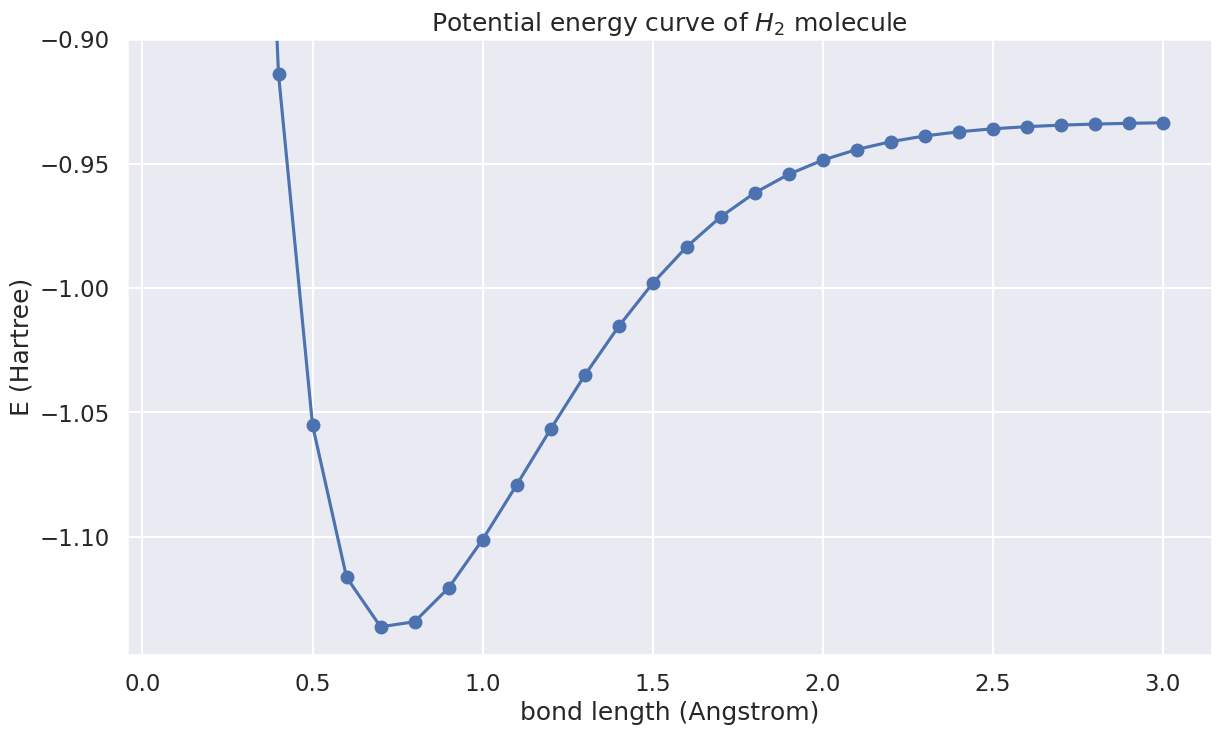

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("talk")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 18
plt.plot(np.linspace(0.1, 3.0, 30), energy_list, "-o")
plt.title("Potential energy curve of $H_2$ molecule")
plt.xlabel("bond length (Angstrom)")
plt.ylabel("E (Hartree)")
plt.ylim(min(energy_list) * 1.01, -0.9)
plt.show()